In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect = True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# columns in 'measurement' table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
#print(columns)

for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# columns in 'station' table
inspector = inspect(engine)
columns = inspector.get_columns('station')
#print(columns)

for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [37]:
Start_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Start_date_query


('2017-08-23')

In [13]:
# 12 months starting from 2012-11-24 (datetime string for plotting purposes)
Start_date = dt.date(2017, 8,23)
Start_date


datetime.date(2017, 8, 23)

In [14]:
# Calculate the date 1 year ago from the last data point in the database
# 12 months before 2017-08-23 (12 months = 365 days )
query_date = dt.date(2017, 8,23) - dt.timedelta(days=365)
print("Query Date", query_date)
query_date

Query Date 2016-08-23


datetime.date(2016, 8, 23)

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results (2016-08-23 to 2017-08-23)
# Perform a query to retrieve the data and precipitation scores
precipitation_12month = session.query(Measurement.date, Measurement.prcp).\
    filter (Measurement.date >= query_date).all()

precipitation_12month

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(precipitation_12month, columns=['Date','Precipitation'])
df.dropna(axis=0, how='any', inplace= True)
df.sort_values(by='Date')
df.set_index('Date', inplace=True)

df.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


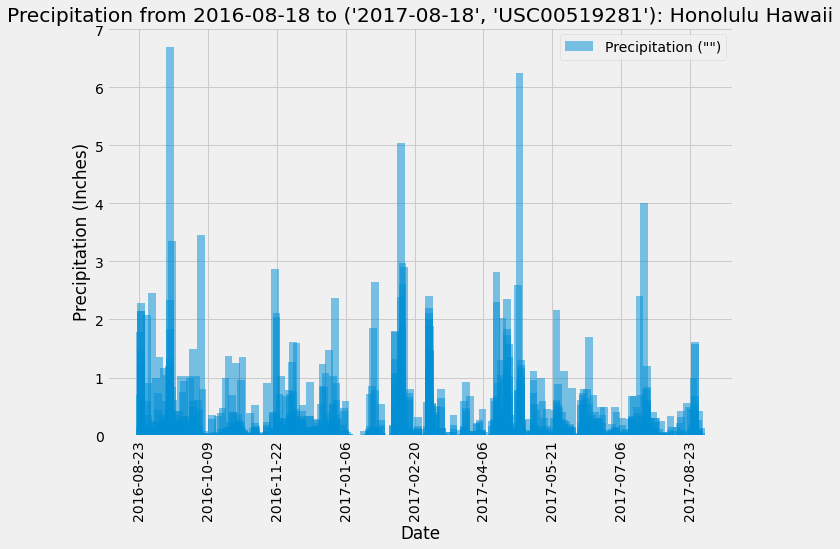

<Figure size 432x288 with 0 Axes>

In [95]:
# Use Pandas Plotting with Matplotlib to plot the data

xx = df.index.tolist()
yy = df['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 , alpha=0.5, align="center",label='Precipitation ("")')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
major_ticks = np.arange(0,365,44.7) #dates along bottom match title (2016-08-23 to 2017-08-23)
plt.xticks(major_ticks, rotation='vertical')

plt.title(f"Precipitation from {query_date} to {Start_date}: Honolulu Hawaii")
plt.xlabel("Date")
plt.ylabel(f"Precipitation (Inches)")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()
plt.savefig('Honolulu_Hawaii_12monthPcrp.png',bbox_inches='tight')

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
#print(columns)

for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(func.count(Station.station)).all()
no_stations


[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.name).all()
active_stations


[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# most active station = 'USC00519281', 2772

lowest_temp_qsetup = [Measurement.station,
            func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs)]

lowest_temp = session.query(*lowest_temp_qsetup).\
            filter(Measurement.station == 'USC00519281')

for station in lowest_temp:
    print(station)



('USC00519281', 54.0, 85.0, 71.66378066378067)


In [73]:
# Choose the station with the highest number of temperature observations.
# calculating start date for station = 'USC00519281' as determined before
query_date2 = session.query(Measurement.date,Measurement.station).\
    filter (Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
query_date2


('2017-08-18', 'USC00519281')

In [74]:
#timestamping start date
Start_date2 = dt.date(2017, 8,18)
Start_date2

datetime.date(2017, 8, 18)

In [78]:
# Query the last 12 months of temperature observation data for this station
#12 months before 2017-08-18
query_date2 = dt.date(2017, 8,18) - dt.timedelta(days=365)
print("Query Date", query_date)
query_date2


Query Date 2016-08-18


datetime.date(2016, 8, 18)

In [83]:
# Query the last 12 months of temperature observation data for this station
temp_observation_12mo = session.query(Measurement.date, Measurement.tobs).\
    filter (Measurement.date >= query_date2).\
    filter (Measurement.station == 'USC00519281').all()

temp_observation_12mo

[('2016-08-18', 80.0),
 ('2016-08-19', 79.0),
 ('2016-08-20', 81.0),
 ('2016-08-21', 79.0),
 ('2016-08-22', 78.0),
 ('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-

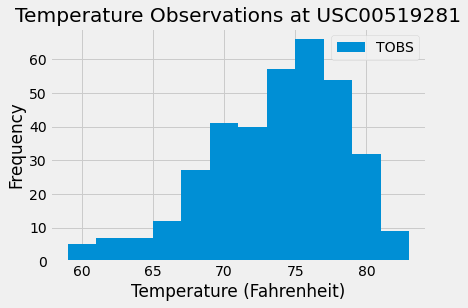

In [94]:
#plot the results as a histogram
plt.hist(df2['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

## Bonus Challenge Assignment

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [100]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28','2011-03-05'))


[(61.0, 69.75510204081633, 75.0)]


c:\Users\Fares\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


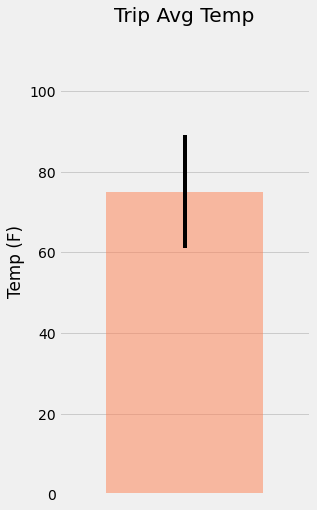

In [105]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin
ax.bar(1, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.3, .3)
fig.show()
plt.savefig('Trip_avg_temp.png',bbox_inches='tight')

In [111]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


sel1 = [Measurement.station,func.sum(Measurement.prcp)
                    ,Station.name
                    ,Station.latitude
                    ,Station.longitude
                    ,Station.elevation]

station_totals = session.query(*sel1).\
        filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= '2011-02-28', func.strftime(Measurement.date) <= '2011-03-05').\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

station_totals
                


[('USC00518838',
  2.33,
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('USC00519281',
  2.23,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  2.19,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  1.96,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  1.45,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 1.44, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519397', 1.38, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918',
  0.63,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [112]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [114]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_startdate = dt.date(2017, 12, 5)
trip_enddate = dt.date(2017, 12, 13)

# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_startdate, trip_enddate)

# Stip off the year and save a list of %m-%d strings
date_list = [d.strftime("%m-%d") for d in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal = [daily_normals(d)[0] for d in date_list]
print(daily_normal)

[(64.0, 70.92156862745098, 78.0), (61.0, 69.3921568627451, 78.0), (58.0, 69.2, 79.0), (60.0, 70.27450980392157, 83.0), (64.0, 71.90196078431373, 80.0), (61.0, 71.24528301886792, 78.0), (64.0, 72.38775510204081, 78.0), (64.0, 70.88235294117646, 79.0), (65.0, 70.9423076923077, 80.0)]


In [115]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df

,tmin,tavg,tmax
Date,,,
2017-12-05,64.0,70.921569,78.0
2017-12-06,61.0,69.392157,78.0
2017-12-07,58.0,69.200000,79.0
2017-12-08,60.0,70.274510,83.0
2017-12-09,64.0,71.901961,80.0
2017-12-10,61.0,71.245283,78.0
2017-12-11,64.0,72.387755,78.0
2017-12-12,64.0,70.882353,79.0
2017-12-13,65.0,70.942308,80.0


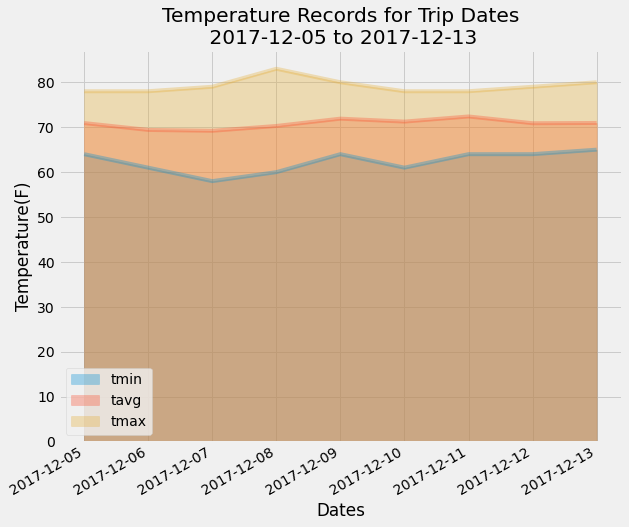

In [117]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.title(f"Temperature Records for Trip Dates\n {trip_startdate} to {trip_enddate}")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.savefig("figures/area_plot.png")